In [21]:
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import kagglehub
import shutil
import os

dataset_path = kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset")
current_dir = os.getcwd()  

for filename in os.listdir(dataset_path):
    file_path = os.path.join(dataset_path, filename)
    shutil.move(file_path, current_dir)

print(f"¡Dataset descargado en: {current_dir}")
print("Archivos:", os.listdir(current_dir ))


Estas columnas son ideales para modelos como XGBoost o Gradient Boosting, donde puedes explotar relaciones no lineales o jerárquicas:

BMI (Continuous)

Descripción: Índice de Masa Corporal (valor numérico continuo).

Importante: Factor clave para diabetes y enfermedades metabólicas.

GenHlth (Ordinal: 1-5)

Descripción: Autoevaluación de salud general:

1 = Excelente, 2 = Muy buena, 3 = Buena, 4 = Regular, 5 = Mala.

Uso: Relación subjetiva pero potente con condiciones crónicas.

MentHlth (Continuous: 0-30)

Descripción: Días de mala salud mental en los últimos 30 días.

Nota: Valores altos pueden correlacionar con estrés crónico (impacta diabetes).

PhysHlth (Continuous: 0-30)

Descripción: Días de mala salud física en los últimos 30 días.

Ejemplo: Dolor crónico o limitaciones físicas.

Age (Ordinal: 1-13)

Descripción: Grupos de edad codificados:

1 = 18-24 años, 2 = 25-29, ..., 13 = 80+ años.

Relevancia: La edad es un predictor fuerte de diabetes tipo 2.

Education (Ordinal: 1-6)

Descripción: Nivel educativo:

1 = Sin educación formal, 6 = Universitario o superior.

Contexto: Menor educación puede asociarse a menos acceso a salud preventiva.

Income (Ordinal: 1-8)

Descripción: Rango de ingresos anuales:

1 = <10,000,‘8‘ => 10,000,‘8‘=>75,000.

Uso: Socioeconomía afecta acceso a alimentación saludable y ejercicio.

Gradient Boosting (Alejandro Cruz)

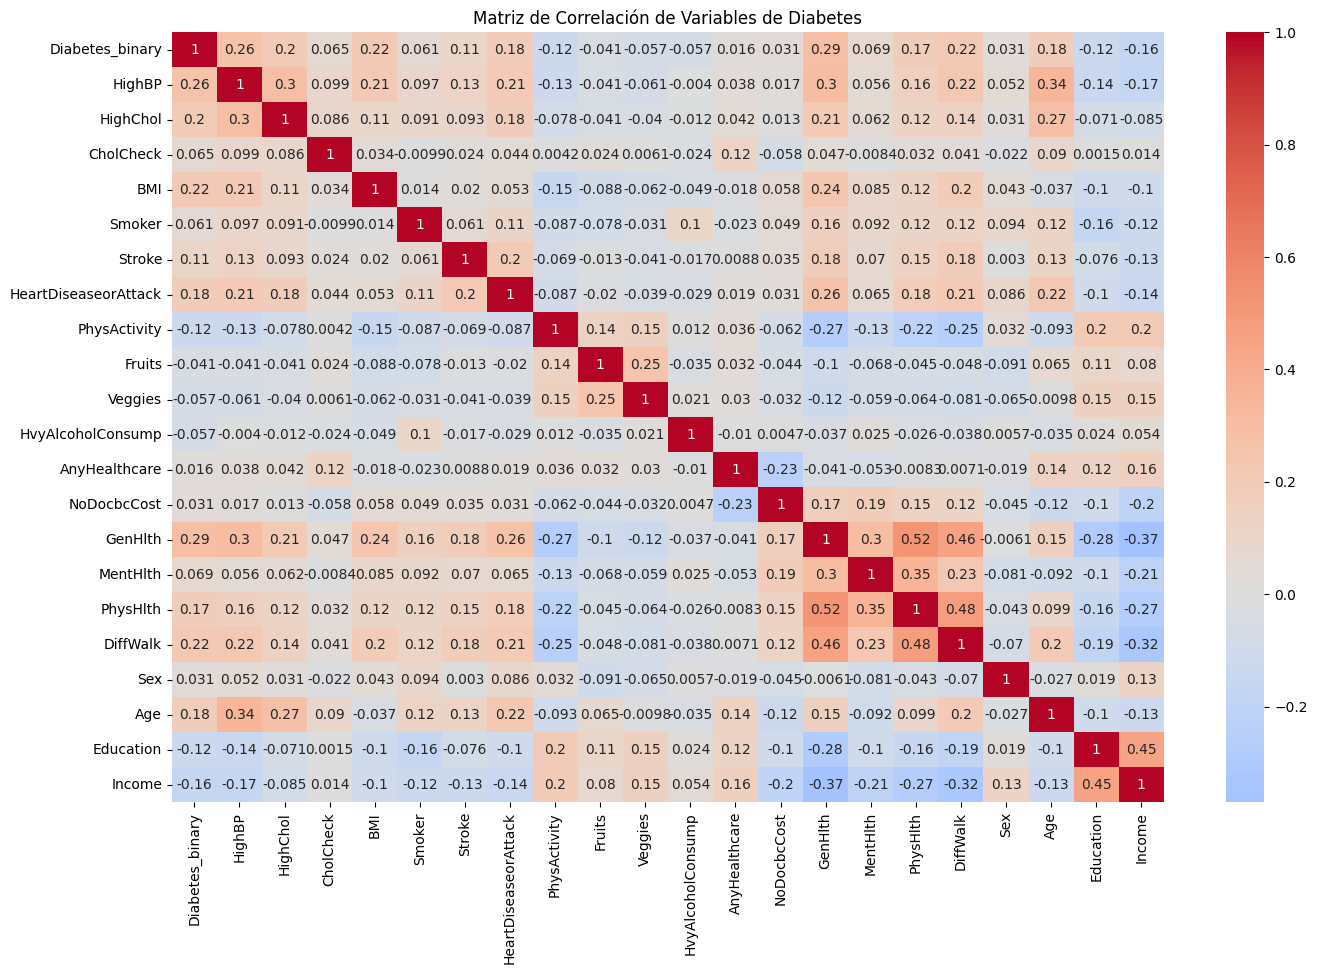

Diabetes_binary         1.000000
GenHlth                 0.293569
HighBP                  0.263129
DiffWalk                0.218344
BMI                     0.216843
HighChol                0.200276
Age                     0.177442
HeartDiseaseorAttack    0.177282
PhysHlth                0.171337
Stroke                  0.105816
MentHlth                0.069315
CholCheck               0.064761
Smoker                  0.060789
NoDocbcCost             0.031433
Sex                     0.031430
AnyHealthcare           0.016255
Fruits                 -0.040779
Veggies                -0.056584
HvyAlcoholConsump      -0.057056
PhysActivity           -0.118133
Education              -0.124456
Income                 -0.163919
Name: Diabetes_binary, dtype: float64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('diabetes_binario_2015.csv')

correlation_matrix = data.corr()
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación de Variables de Diabetes')
plt.show()

In [18]:
low_corr_vars = [
    'Stroke', 'MentHlth', 'CholCheck', 'Smoker', 'NoDocbcCost', 
    'Sex', 'AnyHealthcare', 'Fruits', 'Veggies', 'HvyAlcoholConsump'
]
data_clean = data.drop(columns=low_corr_vars)
print(data_clean.isnull().sum())
data_clean = data_clean.dropna()

Diabetes_binary         0
HighBP                  0
HighChol                0
BMI                     0
HeartDiseaseorAttack    0
PhysActivity            0
GenHlth                 0
PhysHlth                0
DiffWalk                0
Age                     0
Education               0
Income                  0
dtype: int64


In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_vars = ['BMI', 'Age', 'PhysHlth']
data_clean[num_vars] = scaler.fit_transform(data_clean[num_vars])
data_clean = pd.get_dummies(data_clean, columns=['Education', 'Income'], drop_first=True)

In [22]:
from imblearn.over_sampling import SMOTE

X = data_clean.drop('Diabetes_binary', axis=1)
y = data_clean['Diabetes_binary']

# Aplicar SMOTE solo si el desbalance es significativo
if y.value_counts()[0] / len(y) > 0.7:  
    X, y = SMOTE().fit_resample(X, y)
    data_clean = pd.concat([X, y], axis=1)

In [23]:
# Para BMI (evitar valores extremos)
Q1 = data_clean['BMI'].quantile(0.05)
Q3 = data_clean['BMI'].quantile(0.95)
data_clean = data_clean[(data_clean['BMI'] >= Q1) & (data_clean['BMI'] <= Q3)]

In [24]:
print(f"Dataset original: {data.shape}")
print(f"Dataset limpio: {data_clean.shape}")
print("\nVariables finales:", list(data_clean.columns))

Dataset original: (253680, 22)
Dataset limpio: (399364, 22)

Variables finales: ['HighBP', 'HighChol', 'BMI', 'HeartDiseaseorAttack', 'PhysActivity', 'GenHlth', 'PhysHlth', 'DiffWalk', 'Age', 'Education_2.0', 'Education_3.0', 'Education_4.0', 'Education_5.0', 'Education_6.0', 'Income_2.0', 'Income_3.0', 'Income_4.0', 'Income_5.0', 'Income_6.0', 'Income_7.0', 'Income_8.0', 'Diabetes_binary']


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = data.drop('Diabetes_binario', axis=1)
y = data['Diabetes_binario']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
db_modelo = GradientBoostingClassifier()

xgb_modelo = XGBClassifier()

Regresión Lineal y Polinómica(Álvaro Prado)

Importacion de librerias

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

Carga de datos y limpieza del dataset

In [12]:
# Cargar el archivo CSV
file_path = "diabetes_binario_2015.csv"
df = pd.read_csv(file_path)

# Convertir todas las columnas a tipo numérico
df = df.apply(pd.to_numeric, errors='coerce')

# Eliminar filas con valores nulos
df_clean = df.dropna()

# Eliminar duplicados
df_clean = df_clean.drop_duplicates()


Selección de variables y división de datos

In [13]:
# Seleccionar las variables
X = df_clean[['BMI']].values  # Variable independiente
y = df_clean['Diabetes_binary'].values  # Variable dependiente

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Regresión Lineal

In [14]:
# Regresión Lineal
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)


Regresión Polinómica (grado 2)

In [15]:
# Regresión Polinómica (grado 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)
poly_reg = LinearRegression()
poly_reg.fit(X_poly, y_train)
X_test_poly = poly.transform(X_test)
y_pred_poly = poly_reg.predict(X_test_poly)


Evaluacion de modelos

In [16]:
# Evaluación de modelos
mse_lin = mean_squared_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

# Mostrar métricas
print("Métricas de Regresión Lineal:")
print(f"MSE: {mse_lin:.4f}")
print(f"R²: {r2_lin:.4f}")

print("\nMétricas de Regresión Polinómica (Grado 2):")
print(f"MSE: {mse_poly:.4f}")
print(f"R²: {r2_poly:.4f}")


Métricas de Regresión Lineal:
MSE: 0.1251
R²: 0.0415

Métricas de Regresión Polinómica (Grado 2):
MSE: 0.1241
R²: 0.0488


 Visualización de resultados

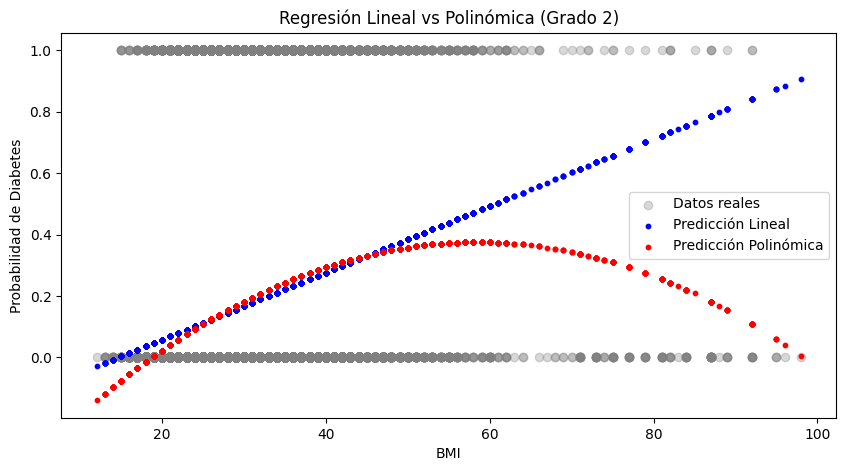

In [17]:
# Visualización de resultados
plt.figure(figsize=(10, 5))
plt.scatter(X_test, y_test, color='gray', alpha=0.3, label="Datos reales")
plt.scatter(X_test, y_pred_lin, color='blue', s=10, label="Predicción Lineal")
plt.scatter(X_test, y_pred_poly, color='red', s=10, label="Predicción Polinómica")
plt.xlabel("BMI")
plt.ylabel("Probabilidad de Diabetes")
plt.legend()
plt.title("Regresión Lineal vs Polinómica (Grado 2)")
plt.show()


### KNN (Miguel Sedano) 

1. Importación de librerías

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


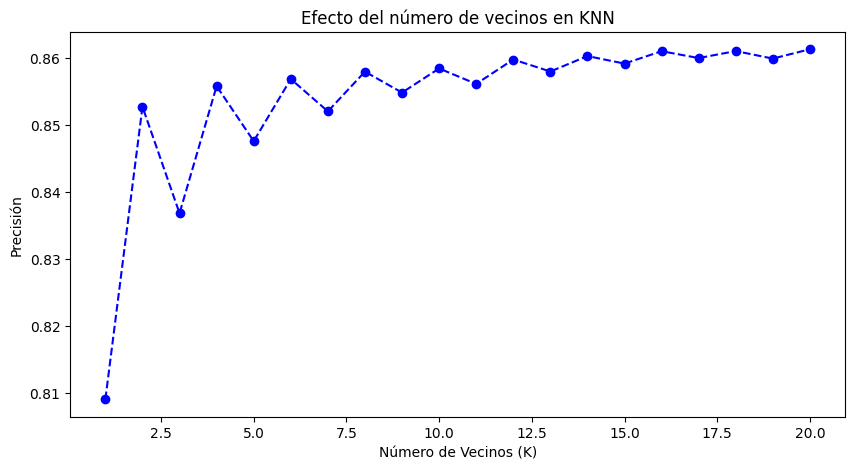

Mejor valor de K: 20
Matriz de Confusión:
[[42957   710]
 [ 6325   744]]

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92     43667
         1.0       0.51      0.11      0.17      7069

    accuracy                           0.86     50736
   macro avg       0.69      0.54      0.55     50736
weighted avg       0.82      0.86      0.82     50736



In [11]:
# Cargar el dataset
df = pd.read_csv("diabetes_binario_2015.csv")

# Verificar valores nulos
df.dropna(inplace=True)

# Separar características y variable objetivo
X = df.drop(columns=["Diabetes_binary"])
y = df["Diabetes_binary"]

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Aplicar KNN con diferentes valores de K
k_values = range(1, 21)
accuracy_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

# Graficar la precisión en función de K
plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracy_scores, marker='o', linestyle='dashed', color='b')
plt.xlabel('Número de Vecinos (K)')
plt.ylabel('Precisión')
plt.title('Efecto del número de vecinos en KNN')
plt.show()

# Selección del mejor K basado en la precisión máxima
best_k = k_values[np.argmax(accuracy_scores)]
print(f"Mejor valor de K: {best_k}")

# Entrenar modelo con el mejor K
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)
y_pred_best = knn_best.predict(X_test)

# Evaluación del modelo
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_best))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_best))
